In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Credit Card Data/creditcard.csv')
df

FileNotFoundError: [Errno 2] No such file or directory: 'creditcard.csv'

In [ ]:
df['Class'].value_counts()

The Dataset is highly imbalanced.

### **Exploratory Data Analysis (EDA)**

In [ ]:

X = df

plt.figure(figsize=(20, 10))
sns.heatmap(X.corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Matrix - Before Undersampling', fontsize=20)
plt.show()

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

X = df.drop('Class', axis=1)
y = df['Class']
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)

new_df = pd.concat([X_res, y_res], axis=1)

plt.figure(figsize=(15, 15))
sns.heatmap(new_df.corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Matrix - After Undersampling', fontsize=20)
plt.show()

The features V10, V12 and V14 are negatively correlated.

In [ ]:
new_df['Class'].value_counts()

In [ ]:
plt.figure(figsize=(18, 6))

# Create a box plot for V10
plt.subplot(1, 3, 1)  # 1 row, 3 columns, position 1
sns.boxplot(x=new_df['Class'], y=new_df['V10'], data=new_df)
plt.title('Box Plot of V10 by Class')

# Create a box plot for V12
plt.subplot(1, 3, 2)  # 1 row, 3 columns, position 2
sns.boxplot(x=new_df['Class'], y=new_df['V12'], data=new_df)
plt.title('Box Plot of V12 by Class')

# Create a box plot for V14
plt.subplot(1, 3, 3)  # 1 row, 3 columns, position 3
sns.boxplot(x=new_df['Class'], y=new_df['V14'], data=new_df)
plt.title('Box Plot of V14 by Class')

# Show the plots
plt.tight_layout()
plt.show()


### **Removing Outliers**

In [ ]:
# Function to remove outliers based on IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [ ]:
data_filtered = new_df.copy()
data_filtered = remove_outliers(data_filtered, 'V10')
data_filtered = remove_outliers(data_filtered, 'V12')
data_filtered = remove_outliers(data_filtered, 'V14')

In [ ]:
data_filtered

In [ ]:
data_filtered['Class'].value_counts()

In [ ]:
plt.figure(figsize=(18, 6))

# Create a box plot for V10 after removing outliers
plt.subplot(1, 3, 1)  # 1 row, 3 columns, position 1
sns.boxplot(x='Class', y='V10', data=data_filtered)
plt.title('Box Plot of V10 by Class (No Outliers)')

# Create a box plot for V12 after removing outliers
plt.subplot(1, 3, 2)  # 1 row, 3 columns, position 2
sns.boxplot(x='Class', y='V12', data=data_filtered)
plt.title('Box Plot of V12 by Class (No Outliers)')

# Create a box plot for V14 after removing outliers
plt.subplot(1, 3, 3)  # 1 row, 3 columns, position 3
sns.boxplot(x='Class', y='V14', data=data_filtered)
plt.title('Box Plot of V14 by Class (No Outliers)')

# Show the plots
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.manifold import TSNE
from imblearn.under_sampling import RandomUnderSampler


X = data_filtered.drop('Class', axis=1)
y = data_filtered['Class']
tsne = TSNE(n_components=2, random_state=42)

In [ ]:
X_tsne = tsne.fit_transform(X)

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[y == 0, 0], X_tsne[y == 0, 1], label='Non-Fraud', alpha=0.5, s=5)
plt.scatter(X_tsne[y == 1, 0], X_tsne[y == 1, 1], label='Fraud', alpha=0.8, s=25, color='r')
plt.title('t-SNE Visualization - After Undersampling')
plt.legend()
plt.show()

The lack of clear separability here signals that distinguishing fraud will likely require a combination of sophisticated methods to accurately capture the subtle differences between fraud and legitimate transactions.

## **Logistic Regression**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc
from imblearn.under_sampling import RandomUnderSampler

X = data_filtered.drop('Class', axis=1)
y = data_filtered['Class']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [ ]:
model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)

In [ ]:
y_pred_prob = model.predict_proba(X_test)[:, 1]

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
auprc = auc(recall, precision)

print(f"AUPRC: {auprc:.4f}")

In [ ]:
import matplotlib.pyplot as plt
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

## **Isolation Forest**

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Separate features and target variable
X = df.drop(columns=['Class'])
y = df['Class']

# Use a smaller subset of the data for faster computation
data_sampled = df.sample(n=50000, random_state=42)
X_sampled = data_sampled.drop(columns=['Class'])
y_sampled = data_sampled['Class']

data_sampled['Class'].value_counts()

In [ ]:
# Initialize and fit the Isolation Forest model
iso_forest = IsolationForest(contamination=0.0017, random_state=42)  # contamination set close to fraud ratio
iso_forest.fit(X_sampled)

# Predict anomalies (-1 indicates outliers by Isolation Forest)
y_pred_sampled = iso_forest.predict(X_sampled)
y_pred_sampled = [1 if pred == -1 else 0 for pred in y_pred_sampled]  # Convert -1 to 1 (fraud) and 1 to 0 (non-fraud)

# Evaluate the model's performance on the sampled data
report_sampled = classification_report(y_sampled, y_pred_sampled, target_names=['Non-Fraud', 'Fraud'])
print(report_sampled)

In [ ]:
accuracy = accuracy_score(y_sampled, y_pred_sampled)
print("Accuracy score for Isolation Forest:", accuracy)

## **Local Outlier factor**

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.0017)

y_pred = lof.fit_predict(X_sampled)
y_pred = [1 if pred == -1 else 0 for pred in y_pred]  # Convert -1 to 1 (fraud) and 1 to 0 (non-fraud)

In [3]:
# DEEp Learning part
# Import required libraries for Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, auc, precision_score, recall_score, f1_score
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from google.colab import files
uploaded = files.upload()

Saving creditcard.csv to creditcard.csv


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping


In [8]:
df = pd.read_csv("creditcard.csv")

X = df.drop("Class", axis=1)
y = df["Class"]

print("Fraud cases:", y.sum())
print("Non-fraud cases:", len(y) - y.sum())


Fraud cases: 492
Non-fraud cases: 284315


In [10]:
# Split data into training and testing sets (stratified to preserve class ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Standardize features (important for neural networks)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [11]:
# Compute class weights to give more importance to fraud class
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

# Convert weights into dictionary format
class_weight_dict = {
    0: class_weights[0],  # Non-fraud
    1: class_weights[1]   # Fraud
}

class_weight_dict


{0: np.float64(0.5008661206149896), 1: np.float64(289.14340101522845)}

In [12]:
# Create a Sequential ANN model
ann = Sequential([
    # Input layer + first hidden layer
    Dense(32, activation="relu", input_shape=(X_train.shape[1],)),

    # Dropout to reduce overfitting
    Dropout(0.3),

    # Second hidden layer
    Dense(16, activation="relu"),

    # Dropout
    Dropout(0.3),

    # Output layer (sigmoid for binary classification)
    Dense(1, activation="sigmoid")
])

# Compile the ANN model
ann.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Display model architecture
ann.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,537 (6.00 KB)

 Trainable params: 1,537 (6.00 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

# Train the ANN
history = ann.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=2048,
    class_weight=class_weight_dict,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.4336 - loss: 0.5240 - val_accuracy: 0.9693 - val_loss: 0.4629
Epoch 2/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8770 - loss: 0.3346 - val_accuracy: 0.9870 - val_loss: 0.3176
Epoch 3/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9433 - loss: 0.2707 - val_accuracy: 0.9877 - val_loss: 0.2293
Epoch 4/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9640 - loss: 0.2361 - val_accuracy: 0.9854 - val_loss: 0.1806
Epoch 5/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9656 - loss: 0.2574 - val_accuracy: 0.9870 - val_loss: 0.1423
Epoch 6/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9738 - loss: 0.1920 - val_accuracy: 0.9872 - val_loss: 0.1217
Epoch 7/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9725 - loss: 0.1954 - val_accuracy: 0.9821 - val_loss: 0.1317
Epoch 8/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9687 - loss: 0.1678 - val_accuracy: 0.9865 - val_los

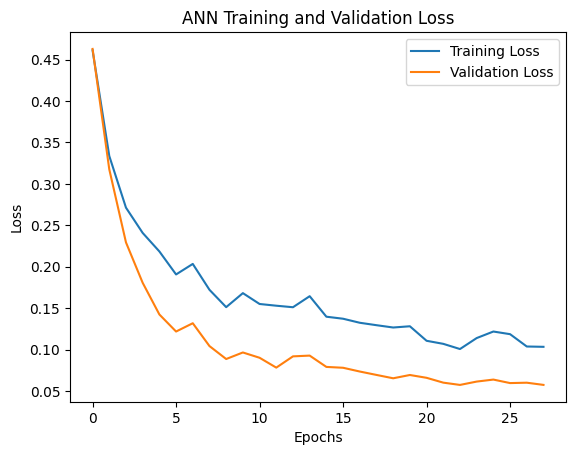

In [14]:
# Plot loss curves
plt.figure()
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("ANN Training and Validation Loss")
plt.legend()
plt.show()


In [15]:
# Predict probabilities
y_pred_prob = ann.predict(X_test).ravel()

# Convert probabilities to class labels
y_pred = (y_pred_prob > 0.5).astype(int)

# Print classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.11      0.90      0.19        98

    accuracy                           0.99     56962
   macro avg       0.55      0.94      0.59     56962
weighted avg       1.00      0.99      0.99     56962

Confusion Matrix:
 [[56127   737]
 [   10    88]]


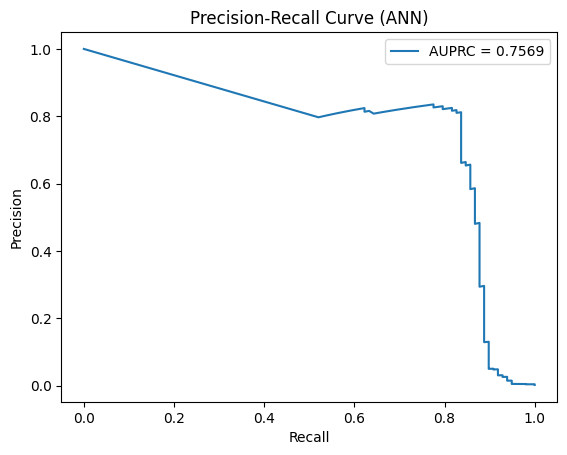

In [16]:
# Compute precision-recall values
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

# Calculate AUPRC
pr_auc = auc(recall, precision)

# Plot Precision–Recall curve
plt.figure()
plt.plot(recall, precision, label=f"AUPRC = {pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (ANN)")
plt.legend()
plt.show()


In [17]:
# Autoencoder is trained only on non-fraud data
X_train_ae = X_train[y_train == 0]

# Test set remains unchanged
X_test_ae = X_test
y_test_ae = y_test


In [18]:
# Number of input features
input_dim = X_train_ae.shape[1]

# Input layer
input_layer = Input(shape=(input_dim,))

# Encoder layers
encoded = Dense(16, activation="relu")(input_layer)
encoded = Dense(8, activation="relu")(encoded)

# Decoder layers
decoded = Dense(16, activation="relu")(encoded)
decoded = Dense(input_dim, activation="linear")(decoded)

# Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Compile autoencoder
autoencoder.compile(optimizer="adam", loss="mse")

# Display model summary
autoencoder.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 30)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,286 (5.02 KB)

 Trainable params: 1,286 (5.02 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Train autoencoder to reconstruct normal transactions
history_ae = autoencoder.fit(
    X_train_ae, X_train_ae,
    epochs=30,
    batch_size=2048,
    validation_split=0.2,
    verbose=1
)


Epoch 1/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 1.0169 - val_loss: 0.8904
Epoch 2/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.8965 - val_loss: 0.7872
Epoch 3/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.7715 - val_loss: 0.7086
Epoch 4/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.6946 - val_loss: 0.6498
Epoch 5/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6471 - val_loss: 0.6103
Epoch 6/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6002 - val_loss: 0.5826
Epoch 7/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5804 - val_loss: 0.5601
Epoch 8/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5601 - val_loss: 0.5431
Epoch 9/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5437 - val_loss: 0.5301
Epoch 10/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5258 - val_loss: 0.5207
Epoch 11/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5215 - val_loss: 0.5122
Epoch 12/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5105 - val_l

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


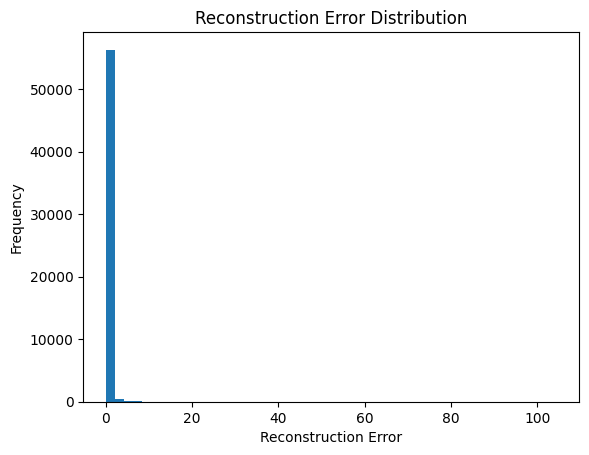

In [20]:
# Reconstruct test data
reconstructions = autoencoder.predict(X_test_ae)

# Calculate reconstruction error
reconstruction_error = np.mean(
    np.square(X_test_ae - reconstructions), axis=1
)

# Plot reconstruction error distribution
plt.figure()
plt.hist(reconstruction_error, bins=50)
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.title("Reconstruction Error Distribution")
plt.show()


In [21]:
# Set threshold (top 1% highest errors)
threshold = np.percentile(reconstruction_error, 99)

# Predict fraud based on reconstruction error
y_pred_ae = (reconstruction_error > threshold).astype(int)

# Print evaluation report
print(classification_report(y_test_ae, y_pred_ae))

# Confusion matrix
cm_ae = confusion_matrix(y_test_ae, y_pred_ae)
print("Confusion Matrix:\n", cm_ae)


              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.14      0.83      0.24        98

    accuracy                           0.99     56962
   macro avg       0.57      0.91      0.62     56962
weighted avg       1.00      0.99      0.99     56962

Confusion Matrix:
 [[56375   489]
 [   17    81]]
